### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('webtraffic.csv')

In [3]:
print(data.head(5))
data.dtypes

     date  sessions
0  1/1/17     88215
1  1/2/17     88484
2  1/3/17     87877
3  1/4/17     86780
4  1/5/17     84622


date        object
sessions     int64
dtype: object

### Convert Dates to DateTime

In [4]:
convert = data['date']
data['date']=pd.to_datetime(data['date'])

In [5]:
data.set_index('date', inplace= True)

In [6]:
data.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
               '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
               '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
               '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
               '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
               '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
               '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
               '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
               '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
      

### Dropping Missing values

In [7]:
data.dropna(axis = 1, how = 'all', inplace = True)
data.dropna(axis = 0, how = 'all', inplace = True)

In [8]:
data.isna().sum()

sessions    0
dtype: int64

### Plotting Website Sessions variability by Date -  Plot (A)

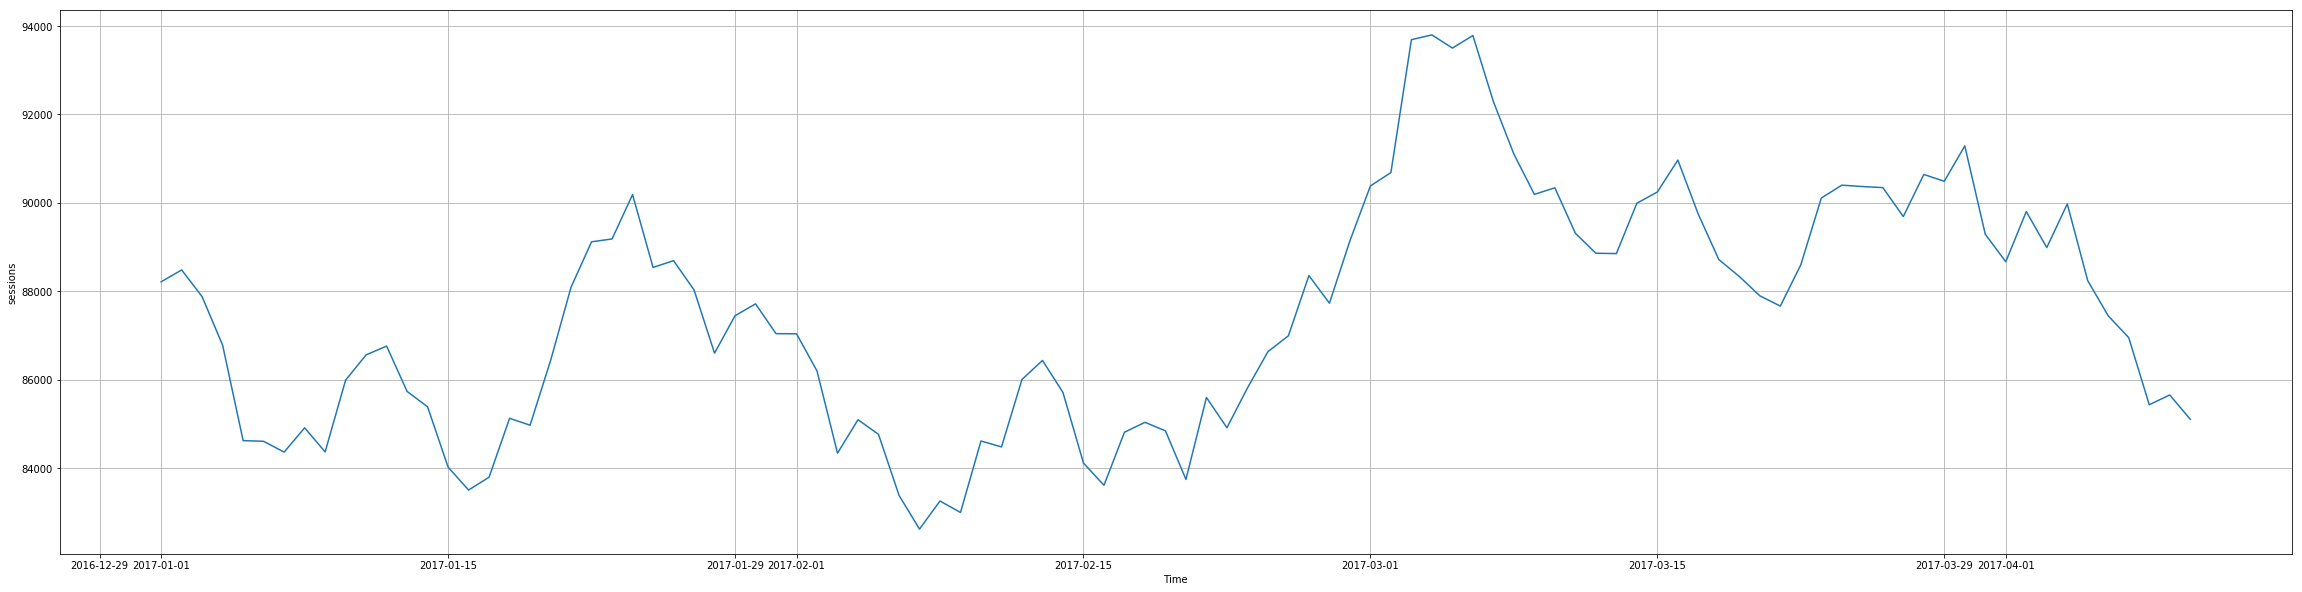

In [9]:
def plot_date(col):
    plt.figure(figsize = (40,10))
    plt.plot(data[col])
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()
    
for col in data.columns:
    plot_date(col)
    

### Applying Facebooks's Prophet

In [10]:
from fbprophet import Prophet
import logging

In [11]:
data.head()

,sessions
date,
2017-01-01,88215
2017-01-02,88484
2017-01-03,87877
2017-01-04,86780
2017-01-05,84622


### Transforming dataframe for Prophet's application

In [12]:
data = data.reset_index()
data.columns = ['ds','y']

### Splitting Data into Train (70) and Test (30)

In [13]:
prediction_size = 30
training_df = data[:-prediction_size]

### Make Predictions yhat with 95% confidence interval upper and lower bound

In [14]:
m = Prophet(interval_width= 0.95)
m.fit(training_df)
future = m.make_future_dataframe(periods  = prediction_size)
forecast = m.predict(future)
forecast.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,85925.747770,83155.008074,89744.982529,85925.747770,85925.747770,550.531039,550.531039,550.531039,550.531039,550.531039,550.531039,0.0,0.0,0.0,86476.278809
1,2017-01-02,85955.758587,82799.951076,89500.466944,85955.758587,85955.758587,171.225813,171.225813,171.225813,171.225813,171.225813,171.225813,0.0,0.0,0.0,86126.984400
2,2017-01-03,85985.769405,83059.339176,89773.362867,85985.769405,85985.769405,273.619412,273.619412,273.619412,273.619412,273.619412,273.619412,0.0,0.0,0.0,86259.388817
3,2017-01-04,86015.780196,82574.758686,89232.458126,86015.780196,86015.780196,-77.017685,-77.017685,-77.017685,-77.017685,-77.017685,-77.017685,0.0,0.0,0.0,85938.762511
4,2017-01-05,86045.790988,82590.383565,88791.023537,86045.790988,86045.790988,-505.942387,-505.942387,-505.942387,-505.942387,-505.942387,-505.942387,0.0,0.0,0.0,85539.848600


In [15]:
forecast['y'] = data['y']

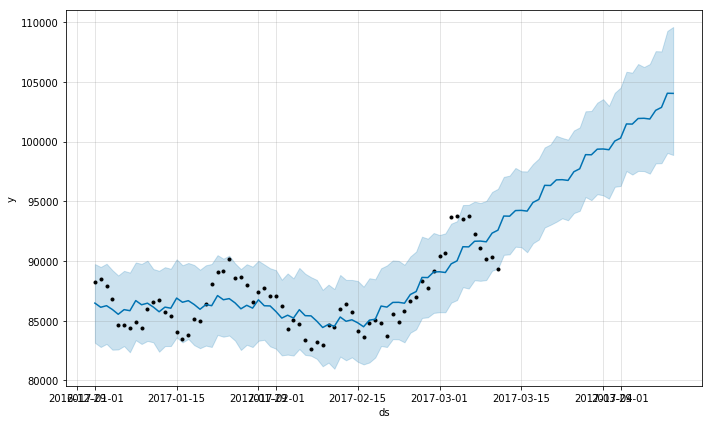

<Figure size 2880x720 with 0 Axes>

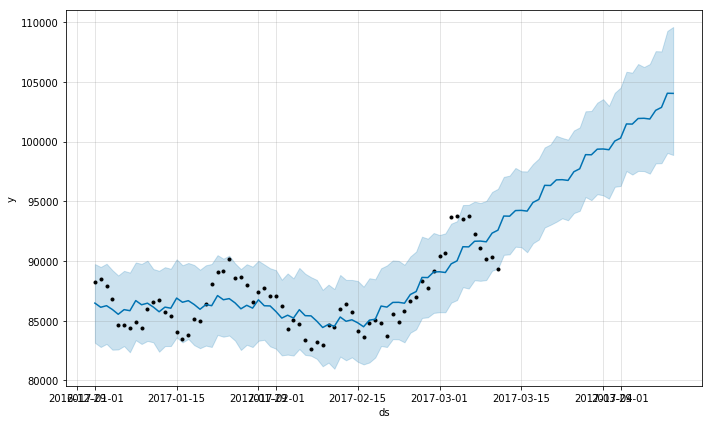

In [16]:
plt.figure(figsize = (40,10))
m.plot(forecast)

### Observation : 
#### Without accounting for any seasonality the model fails to perform
#### The predicted value (thick blue line) seems to lagging behind the actual values ( black dots) by a higher margin in some place
#### Thus the higher MAE error value (see bottom)

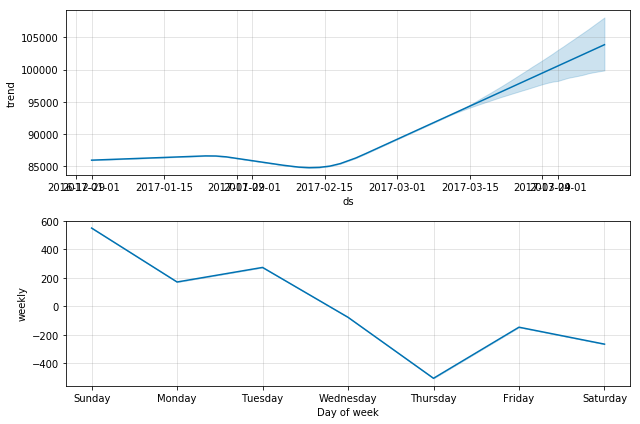

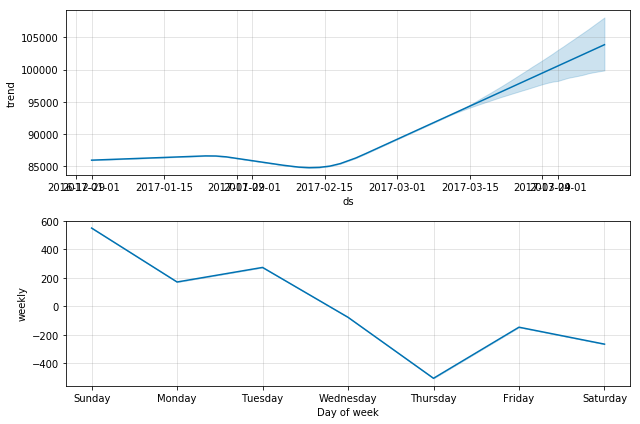

In [17]:
m.plot_components(forecast)

In [18]:
def make_comparison_dataframe(original,forecast):
    return forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']].join(original.set_index('ds'))
                                                                                
cmp_df = make_comparison_dataframe(data,forecast)                                                                                                                                                           

In [19]:
def calculate_forcast_errors(data, prediction_size):
    
    data = data.copy()
    data['e'] = data['y'] - data['yhat']
    data['p'] = (data['e']/data['y']) * 100
    predicted_part = data[-prediction_size:]
    error_mean  = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE' : error_mean('p'), 'MAE' : error_mean('e')}


for error_name,error_value in calculate_forcast_errors(cmp_df,prediction_size).items():
    print(error_name,error_value)

MAPE 10.87178918630459
MAE 9609.55726002538


### Plotting the actual and predicted values with upper and lower bound

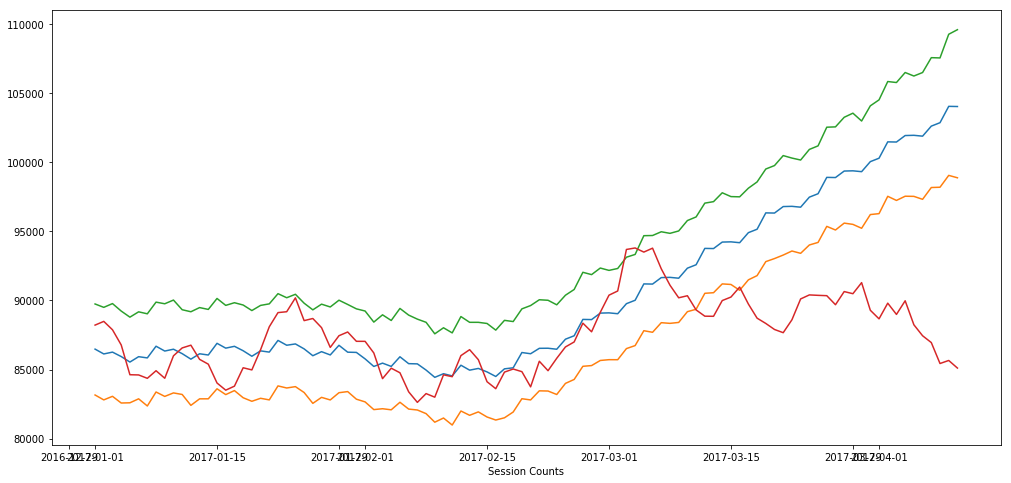

In [20]:
plt.figure(figsize = (17,8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.xlabel('Session Counts')
plt.grid(False)
plt.show()

### Tuning the Model - Adding Seasonality

#### Looking at Plot (A) results, we see that there infact is double seasonality present in the datset
#### As can be seen from the dates between  { 01/12/2017 and 02/13/2017 } ~ 22 days and { 01/24/2019 and 03/03/2017 } ~ 38 days

In [21]:
m2 = Prophet(interval_width= 0.95)
m2.add_seasonality(name = 'A',period = 22,fourier_order= 3)
m2.add_seasonality(name = 'C',period = 38,fourier_order= 3)
m2.fit(training_df)
future2 = m2.make_future_dataframe(periods  = prediction_size)
forecast2 = m2.predict(future2)
forecast2.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,A,A_lower,A_upper,C,...,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,89263.697773,87298.779910,89723.193778,89263.697773,89263.697773,533.187938,533.187938,533.187938,-1740.533020,...,-756.772447,-756.772447,-756.772447,450.572636,450.572636,450.572636,0.0,0.0,0.0,88506.925326
1,2017-01-02,89048.860309,86604.151503,88963.934733,89048.860309,89048.860309,377.961590,377.961590,377.961590,-1889.310006,...,-1285.544498,-1285.544498,-1285.544498,225.803918,225.803918,225.803918,0.0,0.0,0.0,87763.315811
2,2017-01-03,88834.022845,86136.181579,88393.432558,88834.022845,88834.022845,147.136399,147.136399,147.136399,-2022.011139,...,-1580.099986,-1580.099986,-1580.099986,294.774754,294.774754,294.774754,0.0,0.0,0.0,87253.922858
3,2017-01-04,88619.185374,84960.599896,87263.388553,88619.185374,88619.185374,-249.016844,-249.016844,-249.016844,-2117.484023,...,-2535.497343,-2535.497343,-2535.497343,-168.996476,-168.996476,-168.996476,0.0,0.0,0.0,86083.688030
4,2017-01-05,88404.347903,83616.310321,86031.838326,88404.347903,88404.347903,-772.927113,-772.927113,-772.927113,-2155.094240,...,-3586.197508,-3586.197508,-3586.197508,-658.176155,-658.176155,-658.176155,0.0,0.0,0.0,84818.150395


### Plotting model results : The improved model now picks up the trend as can be seen from the below plot

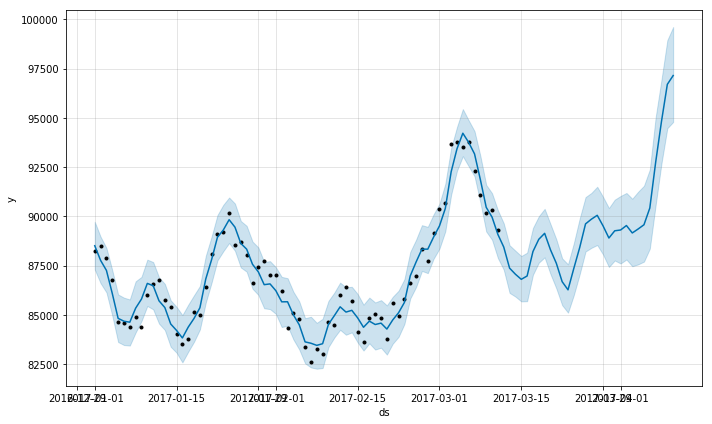

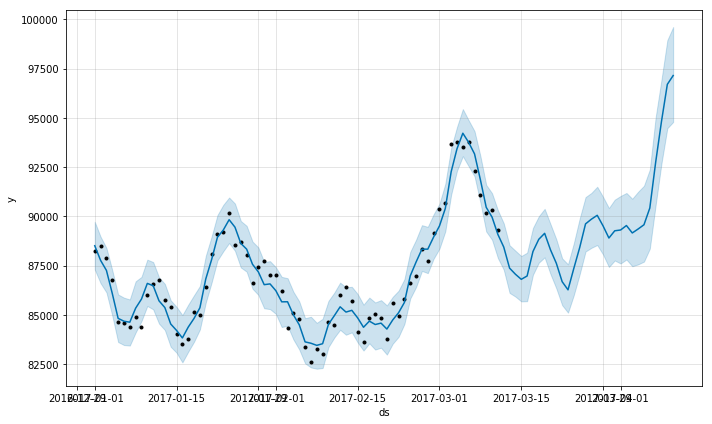

In [22]:
m.plot(forecast2)

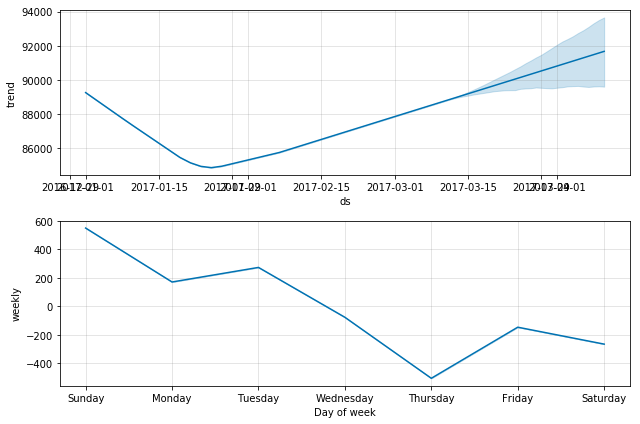

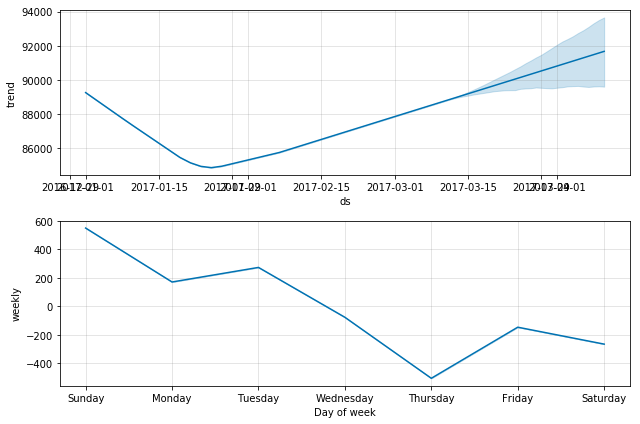

In [23]:
m.plot_components(forecast2)

### Evaluating performance  : the model now has Mean Absolute Percentage Error of 2.8568 and MAE of 2502.898

### This is a significant improvement over the previous MAPE 10.8717 MAE 9609.5572 values 

In [24]:
cmp_df2 = make_comparison_dataframe(data,forecast2)    

In [25]:
for error_name,error_value in calculate_forcast_errors(cmp_df2,prediction_size).items():
    print(error_name,error_value)

MAPE 2.856845178728929
MAE 2502.898885394091


### Making Predictions for next 60 days :  Training over the entire data

In [26]:
prediction_size = 60
training_df = data

In [27]:
training_df.tail()

,ds,y
95,2017-04-06,87444
96,2017-04-07,86951
97,2017-04-08,85434
98,2017-04-09,85655
99,2017-04-10,85105


In [28]:
m3 = Prophet(interval_width= 0.95)
m3.add_seasonality(name = 'A',period = 22,fourier_order= 3)
m3.add_seasonality(name = 'B',period = 38,fourier_order= 3)
m3.fit(training_df)
future3 = m3.make_future_dataframe(periods  = prediction_size)
forecast3 = m3.predict(future3)
forecast3.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,A,A_lower,A_upper,B,...,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,88549.311769,86290.977389,90401.719413,88549.311769,88549.311769,1275.675795,1275.675795,1275.675795,-1445.501587,...,-183.861601,-183.861601,-183.861601,-14.035809,-14.035809,-14.035809,0.0,0.0,0.0,88365.450167
1,2017-01-02,88375.356634,85049.267153,89211.979190,88375.356634,88375.356634,756.004722,756.004722,756.004722,-1693.568930,...,-1273.558728,-1273.558728,-1273.558728,-335.994520,-335.994520,-335.994520,0.0,0.0,0.0,87101.797906
2,2017-01-03,88201.401499,84706.193875,88824.842919,88201.401499,88201.401499,249.558661,249.558661,249.558661,-1890.881905,...,-1386.273539,-1386.273539,-1386.273539,255.049705,255.049705,255.049705,0.0,0.0,0.0,86815.127960
3,2017-01-04,88027.446364,83849.332209,88032.292964,88027.446364,88027.446364,-122.365337,-122.365337,-122.365337,-2007.384587,...,-2024.753969,-2024.753969,-2024.753969,104.995955,104.995955,104.995955,0.0,0.0,0.0,86002.692395
4,2017-01-05,87853.491230,83556.000269,87489.347184,87853.491230,87853.491230,-332.303246,-332.303246,-332.303246,-2020.967029,...,-2292.785066,-2292.785066,-2292.785066,60.485209,60.485209,60.485209,0.0,0.0,0.0,85560.706164


### Predicted DataFrame

In [52]:
forecast3.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,A,A_lower,A_upper,B,...,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
150,2017-05-31,73099.684103,63844.651189,83757.378853,63763.936302,83278.572755,887.653984,887.653984,887.653984,-907.365294,...,85.284645,85.284645,85.284645,104.995955,104.995955,104.995955,0.0,0.0,0.0,73184.968747
151,2017-06-01,72840.524867,63268.463674,84038.363281,63220.037284,83356.209678,1418.320184,1418.320184,1418.320184,-1176.270054,...,302.535338,302.535338,302.535338,60.485209,60.485209,60.485209,0.0,0.0,0.0,73143.060206
152,2017-06-02,72581.365632,62948.731538,83715.437067,62696.955743,83433.002109,1696.922939,1696.922939,1696.922939,-1445.501587,...,372.110036,372.110036,372.110036,120.688685,120.688685,120.688685,0.0,0.0,0.0,72953.475669
153,2017-06-03,72322.206397,61314.184931,83626.117231,62145.869149,83496.854976,1636.571699,1636.571699,1636.571699,-1693.568930,...,-248.186456,-248.186456,-248.186456,-191.189225,-191.189225,-191.189225,0.0,0.0,0.0,72074.019941
154,2017-06-04,72063.047162,60517.808586,82718.744502,61587.905219,83560.707843,1275.675795,1275.675795,1275.675795,-1890.881905,...,-629.241919,-629.241919,-629.241919,-14.035809,-14.035809,-14.035809,0.0,0.0,0.0,71433.805243
155,2017-06-05,71803.887927,59213.197277,82159.928028,61028.538768,83624.642591,756.004722,756.004722,756.004722,-2007.384587,...,-1587.374385,-1587.374385,-1587.374385,-335.994520,-335.994520,-335.994520,0.0,0.0,0.0,70216.513542
156,2017-06-06,71544.728692,58476.662671,81880.807531,60458.334772,83457.278489,249.558661,249.558661,249.558661,-2020.967029,...,-1516.358663,-1516.358663,-1516.358663,255.049705,255.049705,255.049705,0.0,0.0,0.0,70028.370029
157,2017-06-07,71285.569457,57146.834429,81726.437380,59887.234969,83524.085844,-122.365337,-122.365337,-122.365337,-1924.417585,...,-1941.786966,-1941.786966,-1941.786966,104.995955,104.995955,104.995955,0.0,0.0,0.0,69343.782490
158,2017-06-08,71026.410222,56863.662897,81737.978598,59314.842150,83590.961199,-332.303246,-332.303246,-332.303246,-1729.002202,...,-2000.820240,-2000.820240,-2000.820240,60.485209,60.485209,60.485209,0.0,0.0,0.0,69025.589982
159,2017-06-09,70767.250986,56209.449739,81701.204849,58748.713901,83737.222278,-432.485356,-432.485356,-432.485356,-1463.569807,...,-1775.366478,-1775.366478,-1775.366478,120.688685,120.688685,120.688685,0.0,0.0,0.0,68991.884508


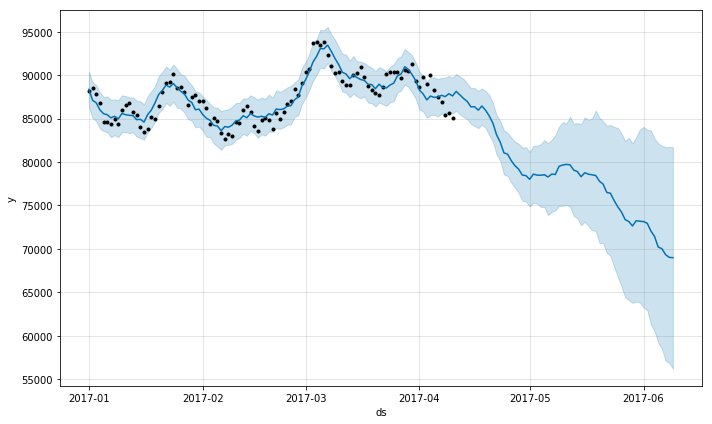

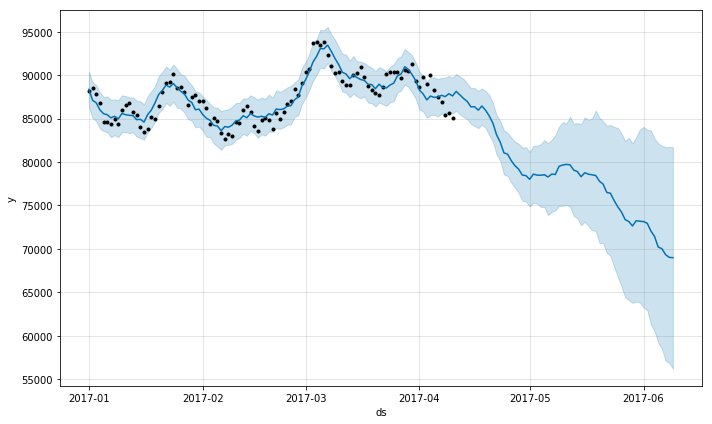

In [30]:
m3.plot(forecast3)

In [42]:
cmp_df3 = make_comparison_dataframe(data,forecast3)    

### Filter on Last 60 days Session Count Results

In [51]:
cmp_df3[['yhat']].tail(60)

,yhat
ds,
2017-04-11,88130.085319
2017-04-12,87733.364133
2017-04-13,87312.963849
2017-04-14,86974.751438
2017-04-15,86355.741820
2017-04-16,86368.227205
2017-04-17,85971.765702
2017-04-18,86439.997119
2017-04-19,85963.620735
